In [1]:
import pandas as pd

data = {
    'Name': ['Alice Smith', 'Bob Jones', 'Charlie Brown', 'Diana Prince'],
    'Age': [25, 45, 35, 28],
    'Salary': [50000, 80000, 62000, 52000],
    'JoinDate': ['2015-06-01', '2010-09-15', '2012-04-30', '2018-01-10'],
    'Department': ['HR', 'Engineering', 'Engineering', 'Marketing'],
}

df = pd.DataFrame(data)
df['JoinDate'] = pd.to_datetime(df['JoinDate'])
df


,Name,Age,Salary,JoinDate,Department
0,Alice Smith,25,50000,2015-06-01,HR
1,Bob Jones,45,80000,2010-09-15,Engineering
2,Charlie Brown,35,62000,2012-04-30,Engineering
3,Diana Prince,28,52000,2018-01-10,Marketing


In [3]:
# Идея — использовать существующие признаки и создавать новые, информативные, которые могут быть полезны для модели.

from datetime import datetime

# Кол-во лет работы в компании
df['YearsAtCompany'] = (pd.Timestamp('today') - df['JoinDate']).dt.days // 365

# Разбивка имени на Имя и Фамилию
df['FirstName'] = df['Name'].apply(lambda x: x.split()[0])
df['LastName'] = df['Name'].apply(lambda x: x.split()[1])

# Бинарный флаг: высокий доход
df['HighSalary'] = (df['Salary'] > 60000).astype(int)

# Возрастной сегмент
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 100], labels=['Young', 'Mid', 'Senior'])

In [4]:
df

,Name,Age,Salary,JoinDate,Department,YearsAtCompany,FirstName,LastName,HighSalary,AgeGroup
0,Alice Smith,25,50000,2015-06-01,HR,10,Alice,Smith,0,Young
1,Bob Jones,45,80000,2010-09-15,Engineering,14,Bob,Jones,1,Senior
2,Charlie Brown,35,62000,2012-04-30,Engineering,13,Charlie,Brown,1,Mid
3,Diana Prince,28,52000,2018-01-10,Marketing,7,Diana,Prince,0,Young


In [5]:
# Удалим колонку 'Name', так как мы уже извлекли FirstName и LastName
df.drop(columns='Name', inplace=True)

# Преобразуем категориальные признаки в числа
df = pd.get_dummies(df, columns=['Department', 'AgeGroup'], drop_first=True)


Salary                  1.000000
Age                     0.993395
AgeGroup_Senior         0.923812
HighSalary              0.842152
YearsAtCompany          0.814903
AgeGroup_Mid            0.048622
Department_Marketing   -0.437595
Department_HR          -0.534838
Name: Salary, dtype: float64


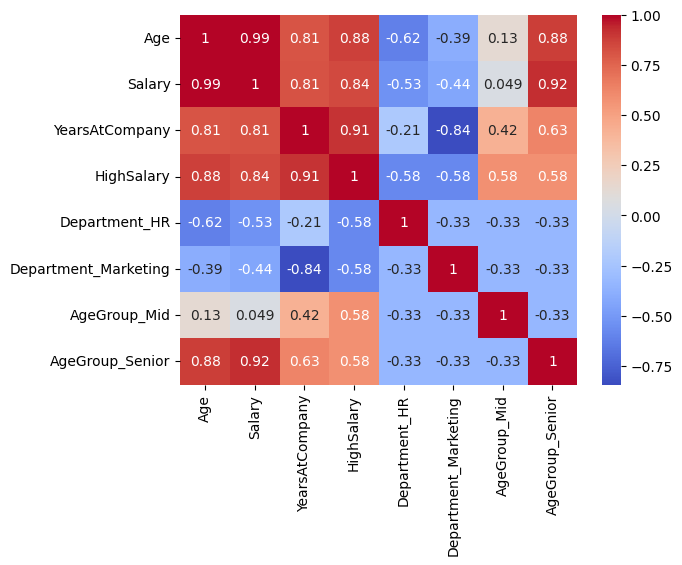

In [6]:
# Выбираем наиболее полезные признаки. Способы:

# 🔹 (а) Корреляция

print(df.corr(numeric_only=True)['Salary'].sort_values(ascending=False))

#🔹 (б) Визуальный анализ / важность (если есть модель)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

#🔹 (в) Удаление низкой дисперсии

# Удалим признаки с одинаковыми значениями у всех
df = df.loc[:, df.nunique() > 1]

In [7]:
df

,Age,Salary,JoinDate,YearsAtCompany,FirstName,LastName,HighSalary,Department_HR,Department_Marketing,AgeGroup_Mid,AgeGroup_Senior
0,25,50000,2015-06-01,10,Alice,Smith,0,True,False,False,False
1,45,80000,2010-09-15,14,Bob,Jones,1,False,False,False,True
2,35,62000,2012-04-30,13,Charlie,Brown,1,False,False,True,False
3,28,52000,2018-01-10,7,Diana,Prince,0,False,True,False,False


## Теперь у нас:
* информативные признаки (YearsAtCompany, HighSalary)
* преобразованные категориальные (Department_Engineering, и т.д.)
* удалены лишние (Name)



In [8]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [9]:
X, y = make_regression(n_samples=300, n_features=10, noise=0.2, random_state=42)
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['target'] = y


In [10]:
X = df.drop(columns='target')
y = df['target']

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_series)


Mutual Information Scores:
 feature_7    0.166397
feature_9    0.146176
feature_4    0.108402
feature_6    0.085898
feature_2    0.072890
feature_0    0.063758
feature_8    0.032652
feature_1    0.000000
feature_3    0.000000
feature_5    0.000000
dtype: float64


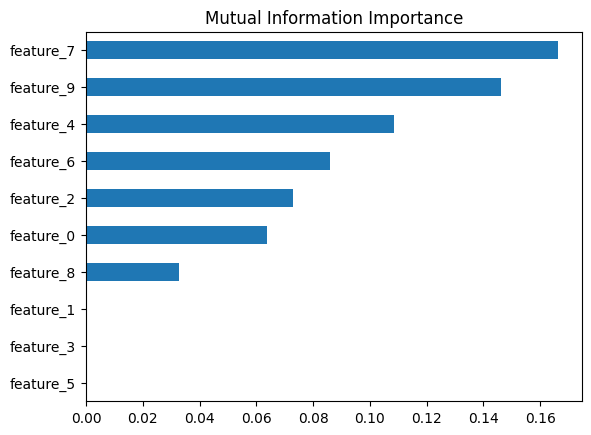

In [11]:
mi_series.plot(kind='barh', title="Mutual Information Importance")
plt.gca().invert_yaxis()
plt.show()


In [12]:
# Допустим, мы хотим оставить только k = 5 лучших признаков:
top_k = 5
selected_features = mi_series.head(top_k).index.tolist()
X_selected = X[selected_features]


In [13]:
# RFE — это итеративное удаление наименее важного признака. Реализуем его вручную по важности модели (например, коэффициентам линейной регрессии):

def rfe_custom(X, y, estimator, min_features_to_select=1):
    remaining_features = list(X.columns)
    rankings = {}
    while len(remaining_features) > min_features_to_select:
        model = estimator.fit(X[remaining_features], y)
        coefs = np.abs(model.coef_)
        weakest_idx = np.argmin(coefs)
        weakest_feature = remaining_features[weakest_idx]
        rankings[weakest_feature] = len(remaining_features)
        print(f"Removing weakest feature: {weakest_feature}")
        remaining_features.pop(weakest_idx)
    for f in remaining_features:
        rankings[f] = 1
    return pd.Series(rankings).sort_values()


In [14]:
model = LinearRegression()
ranking = rfe_custom(X, y, model)
print("\nRFE Ranking (1=best):\n", ranking)


Removing weakest feature: feature_5
Removing weakest feature: feature_3
Removing weakest feature: feature_6
Removing weakest feature: feature_0
Removing weakest feature: feature_2
Removing weakest feature: feature_1
Removing weakest feature: feature_8
Removing weakest feature: feature_4
Removing weakest feature: feature_9

RFE Ranking (1=best):
 feature_7     1
feature_9     2
feature_4     3
feature_8     4
feature_1     5
feature_2     6
feature_0     7
feature_6     8
feature_3     9
feature_5    10
dtype: int64


In [15]:
best_features = ranking[ranking == 1].index.tolist()
X_final = X[best_features]
score = cross_val_score(model, X_final, y, cv=5, scoring='r2')
print("Cross-validated R²:", np.mean(score))


Cross-validated R²: 0.21486766132335466


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


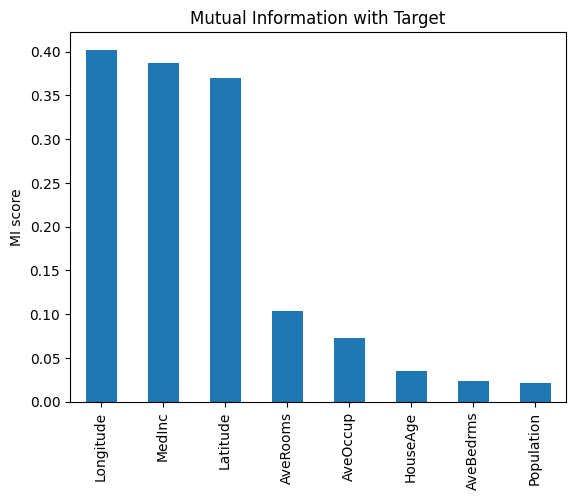

Удаляем признак: AveOccup, R2 = 0.5541
Удаляем признак: Population, R2 = 0.5550
Удаляем признак: AveRooms, R2 = 0.5458
Удаляем признак: AveBedrms, R2 = 0.5448
Удаляем признак: HouseAge, R2 = 0.5331
Удаляем признак: Longitude, R2 = 0.4200
Удаляем признак: Latitude, R2 = 0.4214

Финальные признаки: ['MedInc']


In [16]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Загружаем датасет
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()

# Целевая переменная
y = df['MedHouseVal']
X = df.drop(columns='MedHouseVal')

print(X.head())

from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Оценим взаимную информацию
mi = mutual_info_regression(X, y, discrete_features=False)

# Визуализируем
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

mi_series.plot(kind='bar', title='Mutual Information with Target')
plt.ylabel("MI score")
plt.show()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Копируем признаки
X_selected = X.copy()

# Сохраняем историю
history = []

while X_selected.shape[1] > 1:
    scores = {}
    
    for col in X_selected.columns:
        X_temp = X_selected.drop(columns=col)
        score = cross_val_score(LinearRegression(), X_temp, y, cv=5, scoring='r2').mean()
        scores[col] = score

    # Найдем признак, удаление которого меньше всего ухудшает качество
    worst_feature = max(scores, key=scores.get)
    history.append((worst_feature, scores[worst_feature]))

    print(f"Удаляем признак: {worst_feature}, R2 = {scores[worst_feature]:.4f}")
    X_selected.drop(columns=worst_feature, inplace=True)

print("\nФинальные признаки:", list(X_selected.columns))


In [17]:
from sklearn.feature_selection import f_regression

# F-статистика и p-value
f_scores, p_values = f_regression(X, y)

f_result = pd.DataFrame({
    'Feature': X.columns,
    'F-score': f_scores,
    'p-value': p_values
}).sort_values('F-score', ascending=False)

print(f_result)


      Feature       F-score        p-value
0      MedInc  18556.571631   0.000000e+00
2    AveRooms    487.757462  7.569242e-107
6    Latitude    438.005453   2.939859e-96
1    HouseAge    232.841479   2.761861e-52
3   AveBedrms     45.108576   1.912589e-11
7   Longitude     43.698976   3.923322e-11
4  Population     12.547410   3.976308e-04
5    AveOccup     11.635342   6.483442e-04


 Интерпретация:

F-score — сила линейной зависимости.

p-value — статистическая значимость: чем меньше, тем лучше (например, < 0.05).

      Feature  Importance       Std
6    Latitude    1.217200  0.028367
7   Longitude    1.142371  0.011464
0      MedInc    1.059750  0.019381
3   AveBedrms    0.232404  0.006401
2    AveRooms    0.207504  0.004250
1    HouseAge    0.022135  0.001778
5    AveOccup    0.000920  0.000095
4  Population    0.000010  0.000025


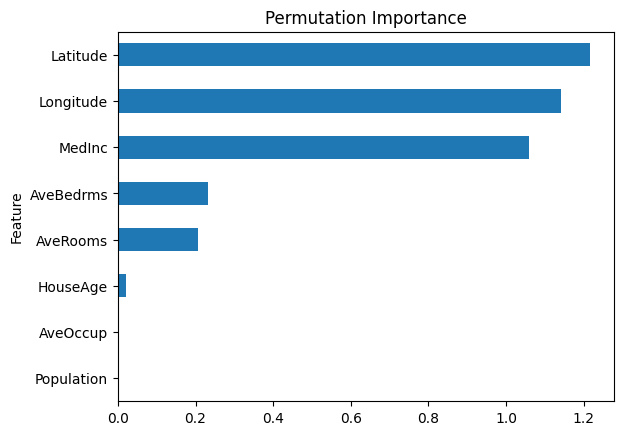

In [18]:
# Permutation Importance (на кросс-валидации)

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Разделим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Модель
model = LinearRegression()
model.fit(X_train, y_train)

# Важность через перестановки
perm = permutation_importance(model, X_test, y_test, scoring='r2', n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.importances_mean,
    'Std': perm.importances_std
}).sort_values('Importance', ascending=False)

print(perm_df)

perm_df.set_index('Feature')['Importance'].plot(kind='barh', title='Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

### 3. Группировка малозначимых признаков в 'other'
#### Идея: признаки с важностью ниже порога — объединим в один категориальный признак 'other'.

Пример (используем mutual_info):


In [19]:
threshold = 0.02  # выбираем порог вручную или по количеству фич

# Важные и слабые признаки
important_features = mi_series[mi_series >= threshold].index.tolist()
weak_features = mi_series[mi_series < threshold].index.tolist()

print("Важные:", important_features)
print("Объединённые в 'other':", weak_features)

# Создаем бинарный индикатор наличия слабого признака
X_transformed = X[important_features].copy()
X_transformed['other'] = X[weak_features].mean(axis=1)


Важные: ['Longitude', 'MedInc', 'Latitude', 'AveRooms', 'AveOccup', 'HouseAge', 'AveBedrms', 'Population']
Объединённые в 'other': []


## 4. K-группировка признаков по значимости (k-binning)
#### Пусть у нас есть значение важности каждого признака (например, mi_series):

In [20]:

from sklearn.preprocessing import KBinsDiscretizer

# Преобразуем важности в массив
importance_values = mi_series.values.reshape(-1, 1)

# K-биннинг на 3 группы (низкая, средняя, высокая важность)
kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
groups = kbin.fit_transform(importance_values).astype(int).flatten()

# Создадим DataFrame с группами
grouped_features = pd.DataFrame({
    'Feature': mi_series.index,
    'MI': mi_series.values,
    'Group': groups
}).sort_values('Group')

print(grouped_features)

      Feature        MI  Group
5    HouseAge  0.035586      0
6   AveBedrms  0.023900      0
7  Population  0.021215      0
3    AveRooms  0.103384      1
4    AveOccup  0.072412      1
0   Longitude  0.402184      2
1      MedInc  0.387251      2
2    Latitude  0.369270      2


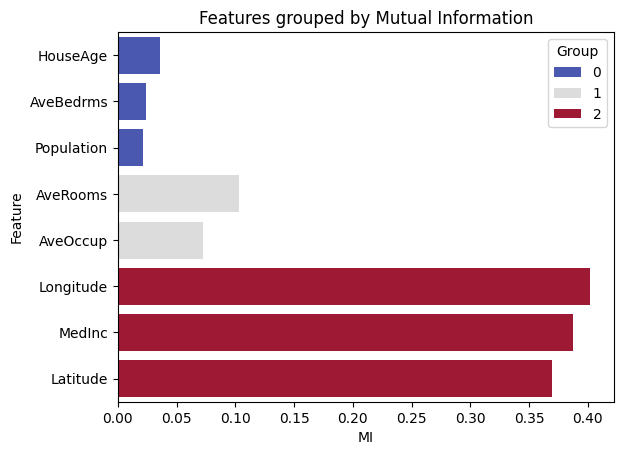

In [21]:
import seaborn as sns

sns.barplot(x='MI', y='Feature', hue='Group', data=grouped_features, dodge=False, palette='coolwarm')
plt.title("Features grouped by Mutual Information")
plt.show()


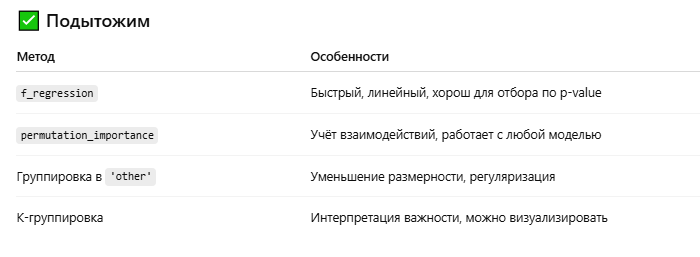

In [22]:
from IPython.display import Image
Image('summary.png')

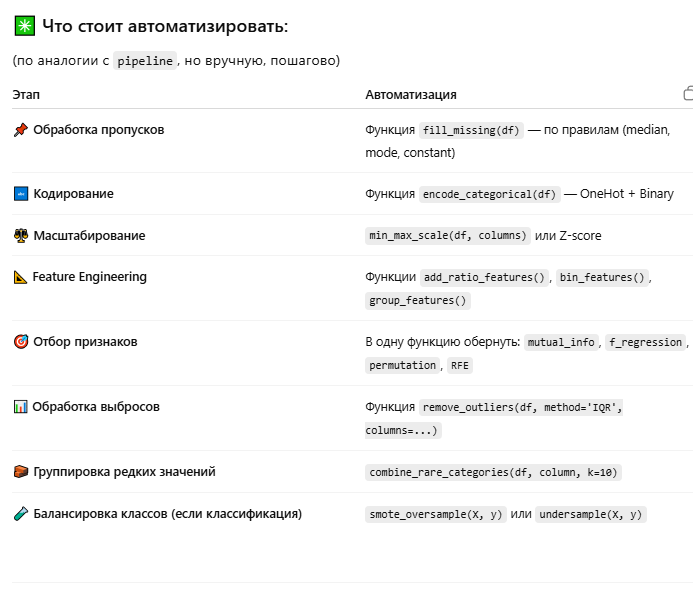

In [23]:
Image('auto.png')

# Пример на калифорния хаузинг

In [24]:
#  1. Импорт и загрузка данных
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Загрузка
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X, y = df.drop(columns='MedHouseVal'), df['MedHouseVal']


In [33]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [38]:
def add_features(X):
    X = X.copy()
    X['RoomsPerHousehold'] = X['AveRooms'] / X['HouseAge']
    X['BedroomsPerRoom'] = X['AveBedrms'] / X['AveRooms']
    X['PopulationPerHousehold'] = X['Population'] / X['HouseAge']
    return X


In [26]:
def scale_features(X):
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return X_scaled


In [27]:
def f_regression_selection(X, y, top_k=5):
    f_vals, p_vals = f_regression(X, y)
    selected = X.columns[np.argsort(f_vals)[-top_k:]]
    return selected.tolist()


In [28]:
def permutation_selection(X, y, top_k=5):
    model = RandomForestRegressor(n_estimators=50, random_state=42)
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    importances = result.importances_mean
    selected = X.columns[np.argsort(importances)[-top_k:]]
    return selected.tolist()


In [29]:
def full_pipeline(X, y, k=5):
    # 1. Feature Engineering
    X_new = add_features(X)
    
    # 2. Масштабирование
    X_scaled = scale_features(X_new)

    # 3. Отбор признаков
    f_selected = f_regression_selection(X_scaled, y, top_k=k)
    perm_selected = permutation_selection(X_scaled, y, top_k=k)

    # 4. Объединение и удаление дубликатов
    selected_features = list(set(f_selected + perm_selected))
    
    return X_scaled[selected_features], selected_features


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_processed, selected_cols = full_pipeline(X_train, y_train, k=5)
print("Выбранные признаки:", selected_cols)
print("Размер итоговой матрицы:", X_processed.shape)



Выбранные признаки: ['Longitude', 'AveOccup', 'AveRooms', 'BedroomsPerRoom', 'HouseAge', 'RoomsPerHousehold', 'Latitude', 'MedInc']
Размер итоговой матрицы: (16512, 8)


Теперь сравним с склерн

In [40]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Загрузка данных
data = fetch_california_housing(as_frame=True)
df = data.frame
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Добавим искусственный категориальный признак
X['Region'] = pd.cut(X['Latitude'], bins=3, labels=['North', 'Center', 'South'])

# 2. Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Указываем типы признаков
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = ['Region']

# 4. Препроцессоры
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

# 5. Общий препроцессор
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# 6. Пайплайн Ridge
ridge_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_regression, k=8)),
    ("regressor", Ridge(alpha=1.0))
])

# 7. Обучение и оценка Ridge
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
print("Ridge R2:", r2_score(y_test, y_pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

# 8. Пайплайн LGBM
lgbm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("feature_selection", SelectKBest(score_func=f_regression, k=8)),
    ("regressor", LGBMRegressor(n_estimators=100, random_state=42))
])

# 9. Обучение и оценка LGBM
lgbm_pipeline.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_test)
print("LGBM R2:", r2_score(y_test, y_pred_lgbm))
print("LGBM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))


Ridge R2: 0.5785128844294547
Ridge RMSE: 0.7431826830978385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947
LGBM R2: 0.8178111848629579
LGBM RMSE: 0.48861217656813616


И последняя тема - дисбаланс классов

Когда один класс встречается значительно чаще другого, модель склонна "игнорировать" редкий класс. Например, в задаче обнаружения мошенничества:

98% транзакций — нормальные

2% — мошеннические

Модель, предсказывающая "нормально" всегда, будет иметь 98% accuracy, но полностью бесполезна.



## 1. Undersampling
#### Суть: уменьшение числа примеров из большинства класса.

**Преимущества** :
* Простота, быстрая обработка.
* Помогает сбалансировать выборку.

**Недостатки**:
* Потеря информации (выкидываются данные).
* Может недообучить модель.

In [ ]:
from sklearn.utils import resample

df_majority = df[df.target == 0]
df_minority = df[df.target == 1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])


## 2. Oversampling
#### Суть: увеличение числа объектов из меньшинства.

**Преимущества**:
* Не теряются данные.
* Работает, если данных мало.

**Недостатки**:
* Возможен overfitting (модель "запоминает" дубликаты).
* Может ухудшить обобщающую способность.

In [ ]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_minority_upsampled, df_majority])


## 3. SMOTE (Synthetic Minority Over-sampling Technique)
#### Суть: вместо копирования создаёт синтетические объекты между точками меньшинства.

**Преимущества**:
* Меньше переобучения, чем у oversampling.
* Больше разнообразия в меньшинстве.

**Недостатки**:
* Работает только с числовыми признаками.
* Может добавлять шум.

In [ ]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

## 4. Взвешивание классов (class_weight)
#### Суть: модели штрафуют себя за ошибку на меньшинстве сильнее, чем на большинстве.

Поддерживается в:
LogisticRegression, RandomForest, XGBoost, LGBM, SVC, RidgeClassifier, и др.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')

# Можно задать вручную:

model = LogisticRegression(class_weight={0:1, 1:10})

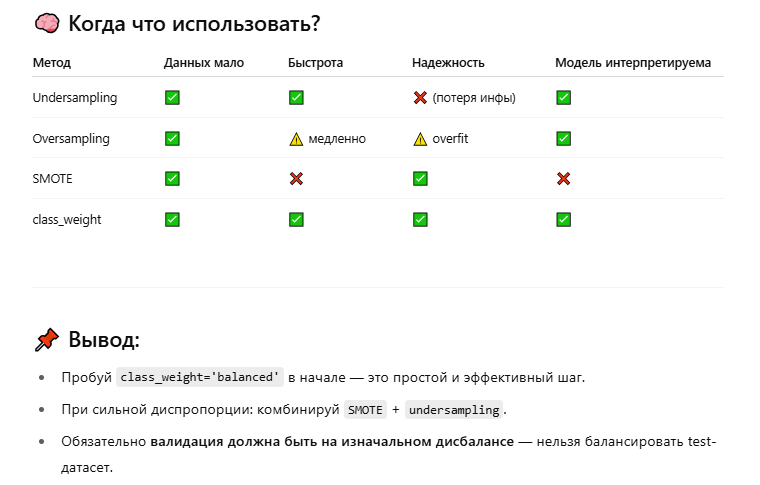

In [42]:
Image('use.png')

И проверим на практике

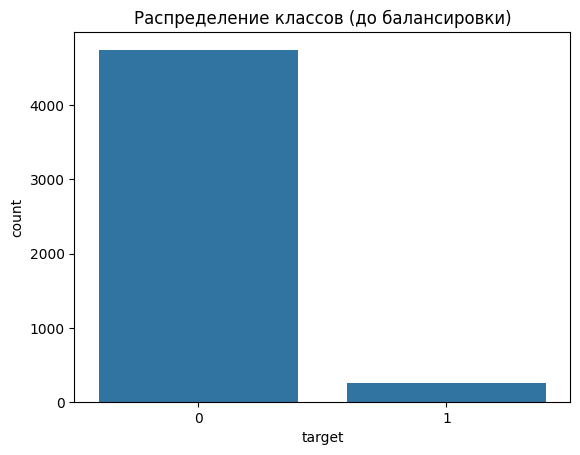

In [43]:
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем сильно дисбалансированный датасет
X, y = make_classification(n_samples=5000, n_features=10, n_informative=6, 
                           n_redundant=2, n_clusters_per_class=1,
                           weights=[0.95, 0.05], flip_y=0,
                           random_state=42)

df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df["target"] = y

# Проверим дисбаланс
sns.countplot(x="target", data=df)
plt.title("Распределение классов (до балансировки)")
plt.show()


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1188
           1       0.84      0.58      0.69        62

    accuracy                           0.97      1250
   macro avg       0.91      0.79      0.84      1250
weighted avg       0.97      0.97      0.97      1250



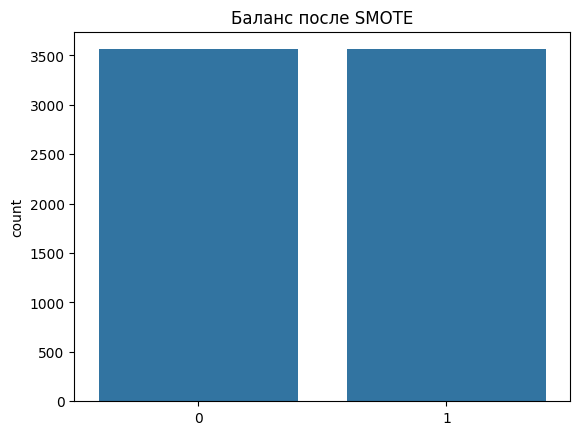

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1188
           1       0.27      0.94      0.42        62

    accuracy                           0.87      1250
   macro avg       0.63      0.90      0.67      1250
weighted avg       0.96      0.87      0.90      1250



In [45]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Проверим новый баланс
sns.countplot(x=y_resampled)
plt.title("Баланс после SMOTE")
plt.show()

# Обучаем модель заново
model.fit(X_resampled, y_resampled)
y_pred_smote = model.predict(X_test)
print(classification_report(y_test, y_pred_smote))


In [46]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

# Обучим заново
model.fit(X_under, y_under)
y_pred_under = model.predict(X_test)
print(classification_report(y_test, y_pred_under))


              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1188
           1       0.25      0.95      0.40        62

    accuracy                           0.86      1250
   macro avg       0.63      0.90      0.66      1250
weighted avg       0.96      0.86      0.89      1250



In [47]:
model_weighted = LogisticRegression(class_weight={0: 1, 1: 20}, max_iter=1000)
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)
print(classification_report(y_test, y_pred_weighted))


              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1188
           1       0.26      0.95      0.41        62

    accuracy                           0.87      1250
   macro avg       0.63      0.91      0.67      1250
weighted avg       0.96      0.87      0.90      1250



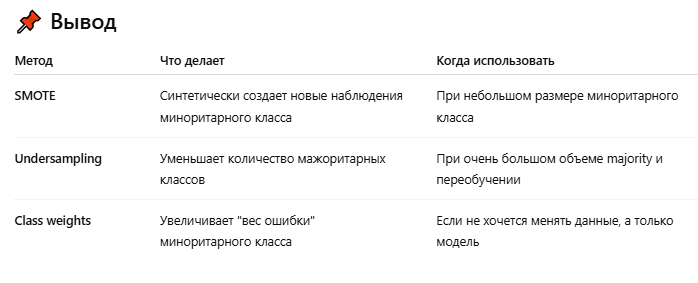

In [48]:
Image('сщтс.png')

In [49]:
from sklearn.datasets import make_classification
import pandas as pd
from collections import Counter

X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.9, 0.1],
    flip_y=0.01,
    random_state=42
)

print(f"Распределение классов: {Counter(y)}")



Распределение классов: Counter({0: 4479, 1: 521})


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

clf_base = RandomForestClassifier(random_state=42)
clf_base.fit(X_train, y_train)
y_pred_base = clf_base.predict(X_test)
print("🔹 Без балансировки")
print(classification_report(y_test, y_pred_base, digits=3))


🔹 Без балансировки
              precision    recall  f1-score   support

           0      0.948     0.999     0.973      1344
           1      0.976     0.532     0.689       156

    accuracy                          0.950      1500
   macro avg      0.962     0.765     0.831      1500
weighted avg      0.951     0.950     0.943      1500



In [51]:
clf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_weighted.fit(X_train, y_train)
y_pred_weighted = clf_weighted.predict(X_test)
print("🔹 Class Weight = 'balanced'")
print(classification_report(y_test, y_pred_weighted, digits=3))


🔹 Class Weight = 'balanced'
              precision    recall  f1-score   support

           0      0.946     0.999     0.971      1344
           1      0.975     0.506     0.667       156

    accuracy                          0.947      1500
   macro avg      0.961     0.752     0.819      1500
weighted avg      0.949     0.947     0.940      1500



In [52]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = clf_smote.predict(X_test)
print("🔹 SMOTE Oversampling")
print(classification_report(y_test, y_pred_sm, digits=3))


🔹 SMOTE Oversampling
              precision    recall  f1-score   support

           0      0.968     0.991     0.979      1344
           1      0.903     0.718     0.800       156

    accuracy                          0.963      1500
   macro avg      0.936     0.855     0.890      1500
weighted avg      0.961     0.963     0.961      1500



In [53]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

clf_rus = RandomForestClassifier(random_state=42)
clf_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = clf_rus.predict(X_test)
print("🔹 Random Undersampling")
print(classification_report(y_test, y_pred_rus, digits=3))


🔹 Random Undersampling
              precision    recall  f1-score   support

           0      0.980     0.923     0.951      1344
           1      0.560     0.840     0.672       156

    accuracy                          0.915      1500
   macro avg      0.770     0.882     0.811      1500
weighted avg      0.937     0.915     0.922      1500



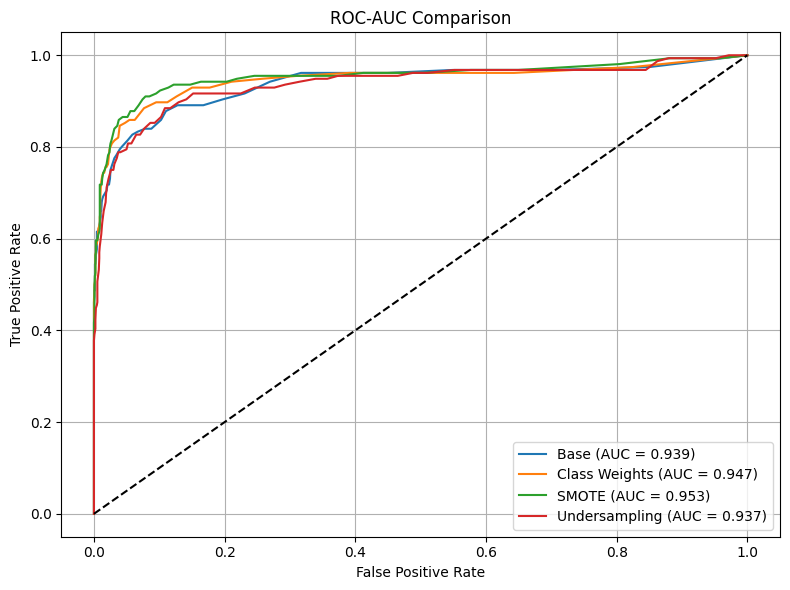

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X_test, y_test, label):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

plt.figure(figsize=(8,6))
plot_roc(clf_base, X_test, y_test, "Base")
plot_roc(clf_weighted, X_test, y_test, "Class Weights")
plot_roc(clf_smote, X_test, y_test, "SMOTE")
plot_roc(clf_rus, X_test, y_test, "Undersampling")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
